## Ebola infected Macaque Sample Composition Trajectory Identification

```
Indices:

- c cell type
- g genes
- m samples
- k deformation polynomial degree
```

In [1]:
import os
import pickle5
import numpy as np
import pandas as pd
#import matplotlib.pylab as plt
import matplotlib
import matplotlib.pyplot
from typing import Dict
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from typing import List, Dict
from boltons.cacheutils import cachedproperty
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
from numbers import Number
import pyro.distributions as dist
import anndata
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

## Parameter Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Helper functions and Classes

In [3]:
from scipy.special import legendre

def legendre_coefficient_mat(k_max, epsilon = 1e-8):
    """
    Return the coefficient matrix of legendre polynomials.
    
    :param k_max: legenre polynomial max degree
    :param epsilon: minimum coefficient value
    """
    
    k_max_internal = k_max + 1
    X_kl = torch.zeros(k_max_internal, k_max_internal)
    for i in range(0, k_max_internal):
        terms = list(legendre(i))
        terms.reverse()
        X_kl[i,:i+1] = torch.tensor(terms,dtype=dtype)
    X_kl = torch.where(X_kl.abs() < epsilon, torch.zeros_like(X_kl), X_kl)
    return X_kl

In [4]:
def NegativeBinomialAltParam(mu, phi):
    """
    Creates a negative binomial distribution.
    
    Args:
        mu (Number, Tensor): mean (must be strictly positive)
        phi (Number, Tensor): overdispersion (must be strictly positive)
    """
    return dist.GammaPoisson(
            concentration= 1 /phi ,
            rate=1 / (mu * phi))

In [5]:
class DeconvolutionDataset:
    """This class represents a bulk and single-cell dataset to be deconvolved in tandem"""
    
    def __init__(
            self,
            sc_anndata: anndata.AnnData,
            sc_celltype_col: str,
            bulk_anndata: anndata.AnnData,
            bulk_time_col: str,
            dtype_np: np.dtype,
            feature_selection_method: str = "common"):

        self.dtype_np = dtype_np
        self.sc_celltype_col = sc_celltype_col
        self.bul_time_col = bulk_time_col

        #self.bulk_anndata = bulk_anndata
        #self.sc_anndata = sc_anndata
        
        # Select common genes and subset/order anndata objects
        selected_genes = self.__select_features(bulk_anndata, sc_anndata, feature_selection_method = feature_selection_method)
        
        
        self.bulk_anndata = bulk_anndata[:,selected_genes]
        self.sc_anndata = sc_anndata[:,selected_genes]
        
        self.num_genes = len(selected_genes)
        
        # TODO: Issue warning if too many genes removed
        
        # Pre-process time values and save inverse function
        self.dpi_time_original_m = self.bulk_anndata.obs[bulk_time_col].values.astype(dtype_np)
        self.time_min = np.min(self.dpi_time_original_m)
        self.time_range = np.max(self.dpi_time_original_m) - self.time_min
        self.dpi_time_m = (self.dpi_time_original_m - self.time_min) / self.time_range
        
        
    def __select_features(self, bulk_anndata, sc_anndata, feature_selection_method, dispersion_cutoff = 5):
        if feature_selection_method == "common":
            selected_genes = list(set(bulk_anndata.var.index).intersection(set(sc_anndata.var.index)))
        elif feature_selection_method == 'overdispersed_bulk':
            x_train = np.log(bulk_anndata.X.mean(0)+1) # log_mu_g
            y_train = np.log(bulk_anndata.X.var(0)+1) # log_sigma_g
            
            X_train = x_train[:, np.newaxis]
            degree = 3
            model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            
            # Select Genes
            sel_over = (y_train - y_pred > 0.0) & (y_train > dispersion_cutoff)
            selected_genes = list(bulk_anndata.var.index[sel_over])
            
        elif feature_selection_method == 'overdispersed_bulk_and_high_sc':
            # Fit polynomial degree
            polynomial_degree = 2
            sc_cutoff = 2 # log scale
            
            # Select overdispersed in bulk
            x_train = np.log(bulk_anndata.X.mean(0)+1) # log_mu_g
            y_train = np.log(bulk_anndata.X.var(0)+1) # log_sigma_g
            
            X_train = x_train[:, np.newaxis]
            
            model = make_pipeline(PolynomialFeatures(polynomial_degree), Ridge(alpha=1e-3))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            
            # Select Genes
            sel_over_bulk = (y_train - y_pred > 0.0) & (y_train > dispersion_cutoff)
            selected_genes_bulk = set(bulk_anndata.var.index[sel_over_bulk])
            
            # Select highly-expressed in single-cell
            
            selected_genes_sc = set(sc_anndata.var.index[np.log(sc_anndata.X.sum(0)+1) > sc_cutoff])
            
            selected_genes = list(selected_genes_bulk.intersection(selected_genes_sc))
            
        print(f'selected {len(selected_genes)} genes')
            
        return selected_genes

# Some plotting code
#             sel_under = (y_train - y_pred < 0.0 ) | (y_train <= 7)
#             lw = 1e-4
#             fig, ax = matplotlib.pyplot.subplots()
#             ax.scatter(x_train[sel_under], y_train[sel_under], linewidth=lw, label="ground truth", c='black', marker='.', s=2)
#             ax.scatter(x_train[sel_over], y_train[sel_over], linewidth=lw, label="ground truth", c='orange', marker='.', s=2)
#             # order for the line
#             o = np.argsort(X_train.T)[0]
#             matplotlib.pyplot.plot(X_train[o,:], y_pred[o], c='red')

        
    @cachedproperty
    def cell_type_str_list(self) -> List[str]:
        return sorted(list(set(self.sc_anndata.obs[self.sc_celltype_col])))
    
    @cachedproperty
    def cell_type_str_to_index_map(self) -> Dict[str, int]:
        return {cell_type_str: index for index, cell_type_str in enumerate(self.cell_type_str_list)}        
    
    @cachedproperty
    def num_cell_types(self) -> int:
        return len(self.cell_type_str_list)
    
    @cachedproperty
    def w_hat_gc(self) -> np.ndarray:
        """Calculate the estimate cell profiles"""
        w_hat_gc = np.zeros((self.num_genes, self.num_cell_types))
        for cell_type_str in self.cell_type_str_list:
            i_cell_type = self.cell_type_str_to_index_map[cell_type_str]
            mask_j = self.sc_anndata.obs[self.sc_celltype_col].values == cell_type_str
            w_hat_gc[:, i_cell_type] = np.sum(self.sc_anndata.X[mask_j,:], axis=-2)
            w_hat_gc[:, i_cell_type] = w_hat_gc[:, i_cell_type] / np.sum(w_hat_gc[:, i_cell_type])
        return w_hat_gc
    
    @cachedproperty
    def bulk_raw_gex_mg(self) -> torch.tensor:
        return torch.tensor(self.bulk_anndata.X, device=device, dtype=dtype)
    
    @cachedproperty
    def t_m(self) -> torch.tensor:
        return torch.tensor(self.dpi_time_m, device=device, dtype=dtype)
    
    def num_bulk_samples -> int:
        return self.bulk_anndata.X


In [69]:
pseudo_time_reg_deconv.dataset.bulk_anndata.X.shape

(52, 3356)

In [6]:
def generate_batch(
    dataset: DeconvolutionDataset,
    device: torch.device,
    dtype: torch.dtype):
    
    return {
        "x_mg": torch.tensor(dataset.bulk_raw_gex_mg, device=device, dtype=dtype),
        "t_m": torch.tensor(dataset.dpi_time_m, device=device, dtype=dtype),
    }

## Model Definition

In [7]:
class TimeRegularizedDeconvolution:
    
    def  __init__(
            self,
            dataset: DeconvolutionDataset,
            basis_functions: str,
            polynomial_degree: int,
            device: device,
            dtype: dtype):
        
        self.dataset = dataset
        self.device = device
        self.dtype = dtype
        self.polynomial_degree = polynomial_degree
        self.basis_functions = basis_functions
        
        # hyperparameters
        self.log_beta_prior_scale = 1.0
        self.log_r_prior_scale = 1.0
        self.tau_prior_scale = 1.0
        self.log_phi_prior_loc = -5.0
        self.log_phi_prior_scale = 1.0
        
        self.unnorm_cell_pop_base_prior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_prior_scale_c = np.ones((self.dataset.num_cell_types,))

        # dist of coefficients of population deformation polynomial
        self.unnorm_cell_pop_deform_prior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_prior_scale_ck = np.ones((self.dataset.num_cell_types, self.polynomial_degree))


        self.init_posterior_global_scale_factor = 0.05
        
        self.log_beta_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_r_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.tau_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_phi_posterior_loc = -5.0
        self.log_phi_posterior_scale = 0.1 * self.init_posterior_global_scale_factor
        
        
        self.unnorm_cell_pop_base_posterior_loc_c = np.zeros((self.dataset.num_cell_types,))
        self.unnorm_cell_pop_base_posterior_scale_c = self.init_posterior_global_scale_factor * np.ones((self.dataset.num_cell_types,))
        
        self.unnorm_cell_pop_deform_posterior_loc_ck = np.zeros((self.dataset.num_cell_types, self.polynomial_degree))
        self.unnorm_cell_pop_deform_posterior_scale_ck = self.init_posterior_global_scale_factor *  np.ones((self.dataset.num_cell_types, self.polynomial_degree))
        
        # cache useful tensors
        self.w_hat_gc = torch.tensor(self.dataset.w_hat_gc, device=device, dtype=dtype)
        
    def model(
            self,
            x_mg: torch.Tensor,
            t_m: torch.Tensor):
        """Main model
        
        :param x_mg: gene expression
        :param t_m: obseration time
        """
        
        # sample log_phi_g
        log_phi_g = pyro.sample(
            'log_phi_g',
            dist.Normal(
                loc=self.log_phi_prior_loc * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_phi_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample log_beta_g
        log_beta_g = pyro.sample(
            'log_beta_g',
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype),
                scale=self.log_beta_prior_scale * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype)).to_event(1))
        
        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_base_prior_loc_c,
                    device=self.device, dtype=self.dtype),
                scale=torch.tensor(
                    self.unnorm_cell_pop_base_prior_scale_c,
                    device=self.device, dtype=self.dtype)).to_event(1))
        
        # Deformation scale is a learnable parameter now
        unnorm_cell_pop_deform_prior_scale_ck = pyro.param("unnorm_cell_pop_deform_prior_scale_ck",
                        torch.tensor(self.unnorm_cell_pop_deform_prior_scale_ck, 
                        device=self.device,
                        dtype=self.dtype),                          
                        constraint = constraints.positive) 
        
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_loc_ck,
                    device=self.device, dtype=self.dtype),
                scale=unnorm_cell_pop_deform_prior_scale_ck).to_event(2))
        
        # calculate useful derived variables
        beta_g = log_beta_g.exp()
        phi_g = log_phi_g.exp()
        
        # Get normalized w_gc
        #unnorm_w_gc = self.w_hat_gc * beta_g[:, None]
        unnorm_w_gc = self.w_hat_gc
        w_gc = unnorm_w_gc / unnorm_w_gc.sum(0)

        if self.basis_functions == 'polynomial':
            tau_km = torch.pow(t_m[None,:], torch.arange(1,self.polynomial_degree + 1, device=self.device)[:,None])  
            deformation_mc = torch.matmul(unnorm_cell_pop_deform_ck, tau_km).transpose(-1,-2)
        elif self.basis_functions == 'legendre':
            # l -- power of the term of the legrenre polynomial
            t_m_prime = 2 * t_m - 1  # discrete times in (-1,1)
            t_lm = torch.pow(t_m_prime[None,:], torch.arange(0,self.polynomial_degree + 1, device=self.device)[:,None])
            c_kl = legendre_coefficient_mat(self.polynomial_degree)[1:,].to(device) # drop constant term
            intermediate_legenre_vals_km = torch.matmul(c_kl, t_lm)
            deformation_mc = torch.matmul(unnorm_cell_pop_deform_ck, intermediate_legenre_vals_km).transpose(-1,-2)
            
        # TODO: add a sample specific proportion sampling from the corresponding time point
        
        cell_pop_unnorm_mc = unnorm_cell_pop_base_c[None,:] + deformation_mc
            
        # Normalize the cell proportions
        cell_pop_mc = torch.nn.functional.softmax(cell_pop_unnorm_mc, dim=-1)
        
        # calculate mean gene expression
        mu_mg = x_mg.sum(-1)[:, None] * torch.matmul(cell_pop_mc, w_gc.transpose(-1, -2))

        with pyro.plate('batch'):
            # observe gene expression
            pyro.sample(
                "x_mg",
                NegativeBinomialAltParam(
                    mu=mu_mg,
                    phi=phi_g[None, :]).to_event(1),
                obs=x_mg)

    def delta_guide(
            self,
            x_mg: torch.Tensor,
            t_m: torch.Tensor):
        """Simple delta guide"""
        
        # variational parameters for log_phi_g
        log_phi_posterior_loc_g = pyro.param(
            "log_phi_posterior_loc_g",
            self.log_phi_posterior_loc * torch.ones(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))

        # variational parameters for log_beta_g
        log_beta_posterior_loc_g = pyro.param(
            "log_beta_posterior_loc_g",
            torch.zeros(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype))        
        
        # variational parameters for unnorm_cell_pop_base_c ("B_c")
        unnorm_cell_pop_base_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_base_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_base_posterior_loc_c,
                device=self.device, dtype=self.dtype))
        
        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform_posterior_loc_ck = pyro.param(
            "unnorm_cell_pop_deform_posterior_loc_ck",
            torch.tensor(
                self.unnorm_cell_pop_deform_posterior_loc_ck,
                device=self.device, dtype=self.dtype))
        
        # posterior sample statements
        log_phi_g = pyro.sample(
            "log_phi_g",
            dist.Delta(
                v=log_phi_posterior_loc_g).to_event(1))

        log_beta_g = pyro.sample(
            "log_beta_g",
            dist.Delta(
                v=log_beta_posterior_loc_g).to_event(1))

        unnorm_cell_pop_base_c = pyro.sample(
            'unnorm_cell_pop_base_c',
            dist.Delta(
                v=unnorm_cell_pop_base_posterior_loc_c).to_event(1))
        
        unnorm_cell_pop_deform_ck = pyro.sample(
            'unnorm_cell_pop_deform_ck',
            dist.Delta(v=unnorm_cell_pop_deform_posterior_loc_ck).to_event(2))
        
        
    def fit_model(self, n_iters = 3000, log_frequency = 100, verbose = True, clear_param_store = True):
        if clear_param_store:
            pyro.clear_param_store()
            
        ## TODO: bring these out
        optim = pyro.optim.Adam({'lr': 1e-3})
        
        self.loss_hist = []
        
        svi = SVI(
            model=self.model,
            guide=self.delta_guide,
            optim=optim,
            loss=Trace_ELBO())
        
        for i_iter in range(n_iters):
            batch_dict = generate_batch(self.dataset, device, dtype)
            loss = svi.step(**batch_dict)
            self.loss_hist.append(loss)
            if verbose:
                if i_iter % log_frequency == 0:
                    print(f"[iteration: {i_iter}]   loss: {self.loss_hist[-1]:.2f}")
                
    def plot_loss(self):
        """Plot the losses during training"""
        fig, ax = matplotlib.pyplot.subplots()
        ax.plot(self.loss_hist)
        ax.set_title('Losses')
        ax.set_xlabel('iteration')
        ax.set_ylabel('ELBO Loss')
        
        return ax
    
    
    def calculate_composition_trajectories(self, time_step=0.01):
        """Calculate the composition trajectories"""

        
        # calculate true times
        if self.basis_functions == 'polynomial':
            times_z = torch.arange(0,1,time_step)
        
            # Take time to appropriate exponent
            times_zk = torch.pow(times_z[:,None], torch.arange(1,self.polynomial_degree + 1,))

            # get the trained params
            base_composition_post_c = pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
            delta_composition_post_ck = pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()

            # Calculate the deltas for each time point
            delta_cz = torch.matmul(delta_composition_post_ck, times_zk.transpose(-1,-2))

            # normalize
            norm_comp_t = torch.nn.functional.softmax(base_composition_post_c[:,None] + delta_cz, dim=0).numpy().T
            
            true_times_z = times_z * self.dataset.time_range + self.dataset.time_min
        elif self.basis_functions == 'legendre':
            times_z = torch.arange(-1,1,time_step)

            # Take time to appropriate exponent
            times_zk = torch.pow(times_z[:,None], torch.arange(1,self.polynomial_degree + 1,))

            # get the trained params
            base_composition_post_c = pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
            delta_composition_post_ck = pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()

            # Calculate the deltas for each time point
            delta_cz = torch.matmul(delta_composition_post_ck, times_zk.transpose(-1,-2))

            # normalize
            norm_comp_t = torch.nn.functional.softmax(base_composition_post_c[:,None] + delta_cz, dim=0).numpy().T
            
            true_times_z = ((times_z+1)/2) * self.dataset.time_range + self.dataset.time_min
        
        self.calculated_trajectories = {
            "times_z": times_z.numpy(), 
            "true_times_z": true_times_z,
            "norm_comp_t": norm_comp_t
        }
    
    
    def get_composition_trajectories(self):
        """Return the composition trajectories"""
        return self.calculated_trajectories
    
    
    def plot_composition_trajectories(self):
        """Plot the composition trajectories"""
        fig, ax  = matplotlib.pyplot.subplots()
        ax.plot(self.calculated_trajectories["true_times_z"], self.calculated_trajectories["norm_comp_t"])
        ax.set_title("Predicted cell proportions")
        ax.set_xlabel("Time")
        ax.legend(ebov_dataset.cell_type_str_list,loc='best',fontsize='small')
        
    def plot_phi_g_distribution(self):
        """Plot the distribution of phi_g"""
        phi_g = pyro.param("log_phi_posterior_loc_g").detach().exp().cpu()
        fig, ax = matplotlib.pyplot.subplots()
        ax.hist(phi_g.numpy(),bins=100)
        ax.set_xlabel('$\phi_g$')
        ax.set_ylabel('Counts')
        
        return ax
    
    def plot_beta_g_distribution(self):
        """Plot distribution of beta_g"""
        beta_g = pyro.param("log_beta_posterior_loc_g").detach().exp().cpu()
        fig, ax = matplotlib.pyplot.subplots()
        ax.hist(beta_g.numpy(),bins=100)
        ax.set_xlabel('$beta_g$')
        ax.set_ylabel('Counts')
        
        return ax

## Train Model

In [8]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [9]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [10]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [11]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


selected 3356 genes


In [12]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 20,
    #basis_functions = "legendre",
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [14]:
pseudo_time_reg_deconv.fit_model(n_iters=5_000, verbose=True, log_frequency=1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


[iteration: 0]   loss: 30370793.59
[iteration: 1000]   loss: 18032904.03
[iteration: 2000]   loss: 11624300.33
[iteration: 3000]   loss: 7409398.96
[iteration: 4000]   loss: 4803077.95


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

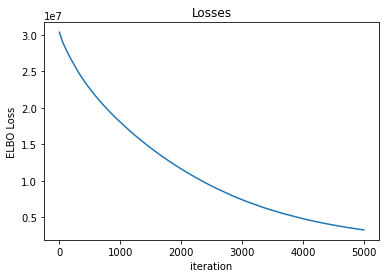

In [15]:
pseudo_time_reg_deconv.plot_loss()

In [16]:
pseudo_time_reg_deconv.calculate_composition_trajectories(time_step=0.001)

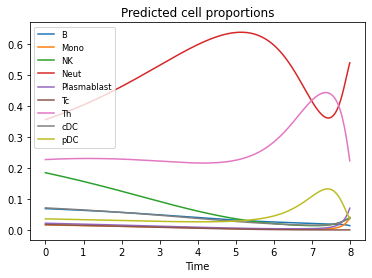

In [17]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

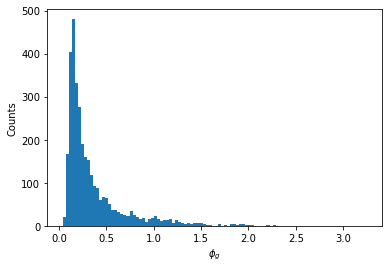

In [35]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

<AxesSubplot:xlabel='$beta_g$', ylabel='Counts'>

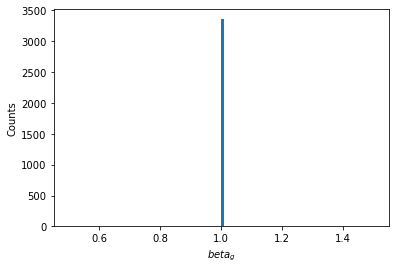

In [36]:
pseudo_time_reg_deconv.plot_beta_g_distribution()

# Synthetic dataset generator

In [79]:
import numpy as np

def sigmoid(x):
  
    z = np.exp(-x)
    sig = 1 / (1 + z)

    return sig


In [135]:
num_cell_types

9

In [136]:
batch_dict = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)
batch_dict.keys()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


dict_keys(['x_mg', 't_m'])

In [207]:
def simulate_with_sigmoid_proportions(start_time = -5, end_time = 5, step = 1, num_samples = 100,
                                     lib_size_mean = 1e6, lib_size_std = 2e5):
    """Simulate bulk data with compositional changes"""
    
    # Discrete timepoints to sample from
    xs = torch.arange(start_time, end_time, step)
    
    # Number of celltypes are same as in main deconvolution
    num_cell_types = pseudo_time_reg_deconv.w_hat_gc.shape[1]
    
    # Sample the times for the samples
    t_m = xs[torch.randint(len(xs), (num_samples,))]
    
    # generate the celltype proportions
    effect_size = torch.rand(num_cell_types)
    shift = torch.rand(num_cell_types)
    magnitude = torch.where(torch.rand(num_cell_types) < 0.5, -1., 1.)
    cell_pop_cm = torch.zeros(num_cell_types, num_samples)
    for i in range(num_cell_types):
        cell_pop_cm[i,:] = torch.Tensor(list(sigmoid(magnitude[i]*x+shift[i]) for x in t_m)) * effect_size[i]
    cell_pop_cm = torch.nn.functional.softmax(cell_pop_cm, dim=0)
    
    # Get phis and betas from main model
    phi_g = pyro.param("log_phi_posterior_loc_g").detach().exp().cpu()
    beta_g = pyro.param("log_beta_posterior_loc_g").detach().exp().cpu()
    
    # Get celltype profiles from the model
    w_hat_gc = pseudo_time_reg_deconv.w_hat_gc.detach().cpu()
    unnorm_w_hat_gc = w_hat_gc
    #unnorm_w_hat_gc = w_hat_gc * beta_g[:,None]
    w_gc = unnorm_w_hat_gc / unnorm_w_hat_gc.sum(0)
    
    # Get some library sizes 
    lib_sizes_m = torch.normal(
        mean=torch.full([num_samples], lib_size_mean), 
        std=torch.full([num_samples], lib_size_std)
    )
    
    # Get the NegBinomial means
    mu_mg = lib_sizes_m[:,None] * torch.matmul(cell_pop_cm.T, w_gc.transpose(-1, -2))
    
    # Sample a full matrix using phis from main model
    x_ng = NegativeBinomialAltParam(mu=mu_mg, phi = phi_g).sample()
    
    return {
        'cell_pop_cm': cell_pop_cm,
        't_m': t_m,
        'x_ng': x_ng,
    }

In [208]:
sim_res = simulate_with_sigmoid_proportions()

In [213]:
def plot_simulated_proportions(sim_res):
    fig, ax = matplotlib.pyplot.subplots()
    o = torch.argsort(sim_res['t_m'])
    ax.plot(sim_res['t_m'][o], sim_res['cell_pop_cm'][:,o].T)
    ax.set_title('Simulated proportions')
    ax.set_xlabel('Set time')
    ax.set_ylabel('Proportions')
    
    return ax

<AxesSubplot:title={'center':'Simulated proportions'}, xlabel='Set time', ylabel='Proportions'>

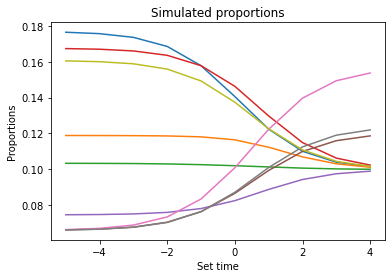

In [214]:
plot_simulated_proportions(sim_res)